# Menyiapkan Library yang Diperlukan

In [1]:
# !pip install opendatasets

In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import json
import glob
import re
import os
import shutil
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

# Load Dataset

In [4]:
file_path = "/kaggle/input/fashion-product-images-small/styles.csv"

In [5]:
df = pd.read_csv(file_path, on_bad_lines='skip')

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


# Eksplorasi Dataset

In [6]:
df_filtered = df[['id', 'articleType', 'baseColour', 'usage']]

df_filtered.head()

,id,articleType,baseColour,usage
0,15970,Shirts,Navy Blue,Casual
1,39386,Jeans,Blue,Casual
2,59263,Watches,Silver,Casual
3,21379,Track Pants,Black,Casual
4,53759,Tshirts,Grey,Casual


## Mengambil Kolom yang Diperlukan

In [7]:
df_UsageType = df_filtered[df_filtered['usage'].notna()]
df_UsageType = df_UsageType[df_filtered['articleType'].notna()]
df_UsageType = df_UsageType[['id', 'usage', 'articleType']]

df_UsageType.head()

/tmp/ipykernel_30/3716085341.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_UsageType = df_UsageType[df_filtered['articleType'].notna()]


,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,59263,Casual,Watches
3,21379,Casual,Track Pants
4,53759,Casual,Tshirts


In [8]:
df_UsageType.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44107 entries, 0 to 44423
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           44107 non-null  int64 
 1   usage        44107 non-null  object
 2   articleType  44107 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


## Menghilangkan Tipe Fashion yang Memiliki Jumlah Kurang dari 100

In [9]:
type_df = df_UsageType['articleType'].value_counts()

type_filtered = type_df[type_df < 100].index
df_UsageType = df_UsageType[~df_UsageType['articleType'].isin(type_filtered)]

df_UsageType['articleType'].value_counts()

articleType
Tshirts                  7067
Shirts                   3214
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   928
Flip Flops                914
Sandals                   895
Briefs                    847
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Jeans                     609
Perfume and Body Mist     603
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Sarees                    427
Earrings                  416
Deodorant                 347
Track Pants               304
Clutches                  290
Sweatshirts               285
Caps                      283
Nail Polish               27

## Mengambil Tipe Fashion yang Sesuai

In [10]:
categories_to_use = ['Tshirts', 'Shirts', 'Casual Shoes', 'Sports Shoes', 'Tops', 'Flip Flops',
    'Sandals', 'Backpacks', 'Formal Shoes', 'Jeans', '  Shorts', 'Trousers',
    'Flats', 'Heels', 'Dresses', 'Skirts', 'Caps', 'Jackets', 'Sweaters', 'Sweatshirts']

df_choosenCategories = df_UsageType[df_UsageType['articleType'].isin(categories_to_use)]
df_choosenCategories['articleType'].value_counts()

articleType
Tshirts         7067
Shirts          3214
Casual Shoes    2845
Sports Shoes    2036
Tops            1762
Heels           1323
Flip Flops       914
Sandals          895
Backpacks        724
Formal Shoes     637
Jeans            609
Trousers         530
Flats            500
Dresses          464
Sweatshirts      285
Caps             283
Sweaters         277
Jackets          258
Skirts           128
Name: count, dtype: int64

In [11]:
# # Menyaring data untuk Tshirts dan Shirts
# tshirt_shirt_df = df_choosenCategories[df_choosenCategories['articleType'].isin(['Tshirts', 'Shirts', 'Casual Shoes', 'Sports Shoes', 'Tops', 'Heels'])]

# # Menghitung total baris untuk Tshirts dan Shirts
# total_tshirt_shirt_records = len(tshirt_shirt_df)

# # Tentukan target jumlah total untuk Tshirts dan Shirts
# target_count = 3500

# # Jika jumlah data lebih dari target, kurangi data
# if total_tshirt_shirt_records > target_count:
#     # Hitung berapa banyak record yang perlu dihapus
#     to_remove = total_tshirt_shirt_records - target_count
    
#     # Pilih secara acak sejumlah `to_remove` record dari Tshirts dan Shirts
#     tshirt_shirt_to_remove = tshirt_shirt_df.sample(n=to_remove, random_state=42)
    
#     # Hapus record yang terpilih dari df_choosenCategories
#     df_choosenCategories_filtered = df_choosenCategories.drop(tshirt_shirt_to_remove.index)
    
#     # Pastikan jumlah total Tshirts dan Shirts menjadi 3000
#     print(f"Jumlah data setelah pengurangan: {len(df_choosenCategories_filtered)}")
# else:
#     # Jika jumlah sudah sesuai, tidak perlu mengubah apa pun
#     df_choosenCategories_filtered = df_choosenCategories

# # Cek hasilnya

# df_choosenCategories = df_choosenCategories_filtered
# print(df_choosenCategories_filtered['articleType'].value_counts())

## Menghilangkan Usage Fashion yang Memiliki Jumlah Kurang dari 100

In [12]:
type_df = df_choosenCategories['usage'].value_counts()

type_filtered = type_df[type_df < 100].index
df_choosenCategories = df_choosenCategories[~df_choosenCategories['usage'].isin(type_filtered)]

df_choosenCategories['usage'].value_counts()

usage
Casual    19525
Sports     3276
Formal     1776
Name: count, dtype: int64

In [13]:
df_choosenCategories = df_choosenCategories.reset_index(drop = True)
df_choosenCategories = df_choosenCategories[['id', 'usage', 'articleType']]

df_choosenCategories.head()

,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,53759,Casual,Tshirts
3,1855,Casual,Tshirts
4,26960,Casual,Shirts


## Memrevisi Beberapa Label pada Dataset

In [14]:
data_revision = [
    {"id": 11906, "articleType": "Flip Flops", "usage": "Casual"},
    {"id": 57491, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 59161, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 40315, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 46291, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 34815, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 14398, "articleType": "Heels", "usage": "Formal"},
    {"id": 57495, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 57490, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 35053, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 43511, "articleType": "Dresses", "usage": "Casual"},
    {"id": 59994, "articleType": "Dresses", "usage": "Casual"},
    {"id": 34069, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 57116, "articleType": "Tops", "usage": "Casual"},
    {"id": 4340, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 26587, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 34652, "articleType": "Casual Shoes", "usage": "Casual"},
    {"id": 10640, "articleType": "Casual Shoes", "usage": "Casual"},
]

df_rev = pd.DataFrame(data_revision)

df_choosenCategories.set_index("id", inplace=True)  
df_rev.set_index("id", inplace=True) 
df_choosenCategories.update(df_rev)  

df_choosenCategories.reset_index(inplace=True)

In [15]:
df_choosenCategories.head()

,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,53759,Casual,Tshirts
3,1855,Casual,Tshirts
4,26960,Casual,Shirts


In [16]:
rules_rev = [
    {"articleType": "Sandals", "usage": "Formal", "new_usage": "Casual"},
    {"articleType": "Flats", "usage": "Sports", "new_usage": "Casual"},
    {"articleType": "Flip Flops", "usage": "Sports", "new_usage": "Casual"},
    {"articleType": "Skirts", "usage": "Sports", "action": "drop"},
    {"articleType": "Sweaters", "usage": "Sports", "new_usage": "Casual"},
]

for rule in rules_rev:
    if "action" in rule and rule["action"] == "drop":
        df_choosenCategories = df_choosenCategories[~((df_choosenCategories["articleType"] == rule["articleType"]) & (df_choosenCategories["usage"] == rule["usage"]))]
    else:
        df_choosenCategories.loc[
            (df_choosenCategories["articleType"] == rule["articleType"]) & (df_choosenCategories["usage"] == rule["usage"]),
            "usage",
        ] = rule["new_usage"]

In [17]:
df_choosenCategories['usage'].value_counts()

usage
Casual    19551
Sports     3255
Formal     1766
Name: count, dtype: int64

In [18]:
df_choosenCategories['articleType'].value_counts()

articleType
Tshirts         7067
Shirts          3181
Casual Shoes    2832
Sports Shoes    2038
Tops            1715
Heels           1311
Flip Flops       915
Sandals          894
Backpacks        713
Formal Shoes     631
Jeans            609
Trousers         523
Flats            486
Dresses          444
Sweatshirts      285
Caps             283
Sweaters         277
Jackets          256
Skirts           112
Name: count, dtype: int64

In [19]:
# df_sample = df_choosenCategories[df_choosenCategories['articleType'] == 'Tshirts']

# grouped = df_sample.groupby('usage')['articleType'].count()
# print(grouped)

In [20]:
# filtered_Tshirts_df = df_choosenCategories[(df_choosenCategories['articleType'] == 'Tshirts') & (df_choosenCategories['usage'] == 'Casual')]

# # Jika ada lebih dari 3000 record, hapus 3000 secara random
# if len(filtered_Tshirts_df) > 1000:
#     # Pilih 3000 index secara random
#     to_drop = filtered_Tshirts_df.sample(n=5110, random_state=42).index
    
#     # Hapus record dari dataset asli
#     df_choosenCategories = df_choosenCategories.drop(index=to_drop)

In [21]:
# filter_condition = (df_choosenCategories['articleType'] == 'Tshirts') & (df_choosenCategories['usage'] == 'Formal')

# to_remove_indices = df_choosenCategories[filter_condition].index[:]
# df_choosenCategories = df_choosenCategories.drop(to_remove_indices)

# # Reset index (opsional, jika ingin indeks rapi kembali)
# df_choosenCategories.reset_index(drop=True, inplace=True)

# df_sample = df_choosenCategories[df_choosenCategories['articleType'] == 'Tshirts']
# grouped = df_sample.groupby('usage')['articleType'].count()
# print(grouped)

In [22]:
# df_sample_Shirts = df_choosenCategories[df_choosenCategories['articleType'] == 'Shirts']

# grouped = df_sample_Shirts.groupby('usage')['articleType'].count()
# print(grouped)

In [23]:
# filtered_Shirts_df = df_choosenCategories[(df_choosenCategories['articleType'] == 'Shirts') & (df_choosenCategories['usage'] == 'Casual')]

# # Jika ada lebih dari 3000 record, hapus 3000 secara random
# if len(filtered_Shirts_df) > 1000:
#     # Pilih 3000 index secara random
#     to_drop = filtered_Shirts_df.sample(n=1315, random_state=42).index
    
#     # Hapus record dari dataset asli
#     df_choosenCategories = df_choosenCategories.drop(index=to_drop)

In [24]:
# df_sample_CasualShoes = df_choosenCategories[df_choosenCategories['articleType'] == 'Casual Shoes']

# grouped = df_sample_CasualShoes.groupby('usage')['articleType'].count()
# print(grouped)

In [25]:
# filtered_CasualShoes_df = df_choosenCategories[(df_choosenCategories['articleType'] == 'Casual Shoes') & (df_choosenCategories['usage'] == 'Casual')]

# # Jika ada lebih dari 3000 record, hapus 3000 secara random
# if len(filtered_CasualShoes_df) > 1000:
#     # Pilih 3000 index secara random
#     to_drop = filtered_CasualShoes_df.sample(n=1812, random_state=42).index
    
#     # Hapus record dari dataset asli
#     df_choosenCategories = df_choosenCategories.drop(index=to_drop)

In [26]:
# filter_condition = (df_choosenCategories['articleType'] == 'Casual Shoes') & (df_choosenCategories['usage'].isin(['Formal', 'Sports']))

# to_remove_indices = df_choosenCategories[filter_condition].index[:]
# df_choosenCategories = df_choosenCategories.drop(to_remove_indices)

# # Reset index (opsional, jika ingin indeks rapi kembali)
# df_choosenCategories.reset_index(drop=True, inplace=True)

# df_sample = df_choosenCategories[df_choosenCategories['articleType'] == 'Casual Shoes']
# grouped = df_sample.groupby('usage')['articleType'].count()
# print(grouped)

In [27]:
# df_sample_SportsShoes = df_choosenCategories[df_choosenCategories['articleType'] == 'Sports Shoes']

# grouped = df_sample_SportsShoes.groupby('usage')['articleType'].count()
# print(grouped)

In [28]:
# filtered_SportsShoes_df = df_choosenCategories[(df_choosenCategories['articleType'] == 'Sports Shoes') & (df_choosenCategories['usage'] == 'Sports')]

# if len(filtered_SportsShoes_df) > 1000:
#     to_drop = filtered_SportsShoes_df.sample(n=1001, random_state=42).index
    
#     # Hapus record dari dataset asli
#     df_choosenCategories = df_choosenCategories.drop(index=to_drop)

In [29]:
# filter_condition = (df_choosenCategories['articleType'] == 'Sports Shoes') & (df_choosenCategories['usage'] == 'Casual')

# to_remove_indices = df_choosenCategories[filter_condition].index[:]
# df_choosenCategories = df_choosenCategories.drop(to_remove_indices)

# # Reset index (opsional, jika ingin indeks rapi kembali)
# df_choosenCategories.reset_index(drop=True, inplace=True)

# df_sample = df_choosenCategories[df_choosenCategories['articleType'] == 'Sports Shoes']
# grouped = df_sample.groupby('usage')['articleType'].count()
# print(grouped)

In [30]:
# df_sample_Tops = df_choosenCategories[df_choosenCategories['articleType'] == 'Tops']

# grouped = df_sample_Tops.groupby('usage')['articleType'].count()
# print(grouped)

In [31]:
# filtered_Tops_df = df_choosenCategories[(df_choosenCategories['articleType'] == 'Tops') & (df_choosenCategories['usage'] == 'Casual')]

# if len(filtered_Tops_df) > 1000:
#     to_drop = filtered_Tops_df.sample(n=701, random_state=42).index
    
#     # Hapus record dari dataset asli
#     df_choosenCategories = df_choosenCategories.drop(index=to_drop)

In [32]:
# df_choosenCategories['articleType'].value_counts()

In [33]:
# df_choosenCategories['usage'].value_counts()

In [34]:
# print(len(df_choosenCategories))

# Menyiapkan Dataset untuk Model

## Mengubah Kategori menjadi Integer

In [35]:
df_choosenCategories['id'] = df_choosenCategories['id'].astype(str) + ".jpg"

article_encoder = LabelEncoder()
usage_encoder = LabelEncoder()

df_choosenCategories['articleType_encoded'] = article_encoder.fit_transform(df_choosenCategories['articleType'])
df_choosenCategories['usage_encoded'] = usage_encoder.fit_transform(df_choosenCategories['usage'])

## Mengapus Baris yang Tidak Memiliki Gambar

In [36]:
import os

image_dir = "/kaggle/input/fashion-product-images-small/images/"
df_choosenCategories['file_path'] = df_choosenCategories['id'].apply(lambda x: os.path.join(image_dir, x))

df_choosenCategories['file_exists'] = df_choosenCategories['file_path'].apply(os.path.exists)

missing_files = df_choosenCategories[~df_choosenCategories['file_exists']]
print(f"Jumlah file gambar yang hilang: {len(missing_files)}")
print("File yang hilang:")
print(missing_files)

df_choosenCategories = df_choosenCategories[df_choosenCategories['file_exists']].drop(columns=['file_exists'])

Jumlah file gambar yang hilang: 4
File yang hilang:
              id   usage articleType  articleType_encoded  usage_encoded  \
3671   39403.jpg  Casual      Shirts                   11              0   
8894   39410.jpg  Casual      Shirts                   11              0   
17811  39401.jpg  Casual       Jeans                    9              0   
20121  39425.jpg  Casual     Tshirts                   18              0   

                                               file_path  file_exists  
3671   /kaggle/input/fashion-product-images-small/ima...        False  
8894   /kaggle/input/fashion-product-images-small/ima...        False  
17811  /kaggle/input/fashion-product-images-small/ima...        False  
20121  /kaggle/input/fashion-product-images-small/ima...        False  


In [37]:
articleType_dict = dict(zip(df_choosenCategories['articleType_encoded'], df_choosenCategories['articleType']))

usage_dict = dict(zip(df_choosenCategories['usage_encoded'], df_choosenCategories['usage']))

print("articleType_encoded : articleType =>", articleType_dict)
print("usage_encoded : usage =>", usage_dict)

articleType_encoded : articleType => {11: 'Shirts', 9: 'Jeans', 18: 'Tshirts', 2: 'Casual Shoes', 5: 'Flip Flops', 16: 'Tops', 10: 'Sandals', 15: 'Sweatshirts', 6: 'Formal Shoes', 4: 'Flats', 13: 'Sports Shoes', 7: 'Heels', 3: 'Dresses', 0: 'Backpacks', 1: 'Caps', 17: 'Trousers', 8: 'Jackets', 14: 'Sweaters', 12: 'Skirts'}
usage_encoded : usage => {0: 'Casual', 1: 'Formal', 2: 'Sports'}


## Memisahkan Dataset untuk Train, Validation, dan Test

In [38]:
train_df, temp_df = train_test_split(df_choosenCategories, test_size=0.3, stratify=df_choosenCategories['articleType'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['articleType'], random_state=42)

In [39]:
train_df.head()

,id,usage,articleType,articleType_encoded,usage_encoded,file_path
872,7939.jpg,Sports,Tshirts,18,2,/kaggle/input/fashion-product-images-small/ima...
23225,3178.jpg,Sports,Sports Shoes,13,2,/kaggle/input/fashion-product-images-small/ima...
22459,31959.jpg,Sports,Sports Shoes,13,2,/kaggle/input/fashion-product-images-small/ima...
3569,4252.jpg,Casual,Tshirts,18,0,/kaggle/input/fashion-product-images-small/ima...
1874,31574.jpg,Casual,Tshirts,18,0,/kaggle/input/fashion-product-images-small/ima...


In [40]:
source_dir = '/kaggle/input/fashion-product-images-small/images/'
target_dir = '/kaggle/working/data/'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for index, row in df_choosenCategories.iterrows():
    image_filename = row['id']

    source_image_path = os.path.join(source_dir, image_filename)
    if os.path.exists(source_image_path):
        target_image_path = os.path.join(target_dir, image_filename)
        shutil.copy(source_image_path, target_image_path)
    else:
        df_choosenCategories = df_choosenCategories.drop(index)
        print(f"File {image_filename} tidak ditemukan di {source_dir}")

image_dir = target_dir

def parse_image(filename, article_label, usage_label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, {"article_output": article_label, "usage_output": usage_label}

def augment_image(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, labels

def generator(df, image_dir):
    for _, row in df.iterrows():
        file_path = os.path.join(image_dir, row['id'])
        yield file_path, row['articleType_encoded'], row['usage_encoded']

def create_dataset_lazy(df, image_dir, batch_size=8, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(df, image_dir),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int64),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset_lazy(train_df, image_dir, batch_size=8, is_training=True)
val_dataset = create_dataset_lazy(val_df, image_dir, batch_size=8, is_training=False)
test_dataset = create_dataset_lazy(test_df, image_dir, batch_size=8, is_training=False)

# Model Klasifikasi Tipe dan Usage

## Membuat dan Melatih Model

In [41]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-10:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='dense_1')(x)
    x = Dense(128, activation='relu', name='dense_2')(x)
    x = Dense(64, activation='relu', name='dense_3')(x)
    x = Dense(32, activation='relu', name='dense_4')(x)

    # Output untuk articleType
    article_output = Dense(len(article_encoder.classes_), activation='softmax', name='article_output')(x)

    # Output untuk usage
    usage_output = Dense(len(usage_encoder.classes_), activation='softmax', name='usage_output')(x)

    model = Model(inputs=base_model.input, outputs=[article_output, usage_output])

    model.compile(
        optimizer='adam',
        loss={
            'article_output': 'sparse_categorical_crossentropy',
            'usage_output': 'sparse_categorical_crossentropy'
        },
        metrics={
            'article_output': 'accuracy',
            'usage_output': 'accuracy'
        }
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        
    patience=3,        
    min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[reduce_lr, early_stop]  # Menambahkan callback ke dalam pelatihan
)

Number of devices: 2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
   2150/Unknown 102s 35ms/step - article_output_accuracy: 0.4727 - loss: 2.2735 - usage_output_accuracy: 0.7958

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2150/2150 ━━━━━━━━━━━━━━━━━━━━ 112s 40ms/step - article_output_accuracy: 0.4728 - loss: 2.2733 - usage_output_accuracy: 0.7958 - val_article_output_accuracy: 0.5133 - val_loss: 2.5262 - val_usage_output_accuracy: 0.8492 - learning_rate: 0.0010
Epoch 2/25
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 86s 39ms/step - article_output_accuracy: 0.6841 - loss: 1.2554 - usage_output_accuracy: 0.8516 - val_article_output_accuracy: 0.7032 - val_loss: 1.7084 - val_usage_output_accuracy: 0.8508 - learning_rate: 0.0010
Epoch 3/25
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - article_output_accuracy: 0.7307 - loss: 1.0795 - usage_output_accuracy: 0.8729 - val_article_output_accuracy: 0.7157 - val_loss: 1.2504 - val_usage_output_accuracy: 0.8888 - learning_rate: 0.0010
Epoch 4/25
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - article_output_accuracy: 0.7590 - loss: 0.9812 - usage_output_accuracy: 0.8807 - val_article_output_accuracy: 0.7710 - val_loss: 1.0921 - val_usage_output_accuracy: 0.8768 - learning_rate: 0

# Mengevaluasi Model

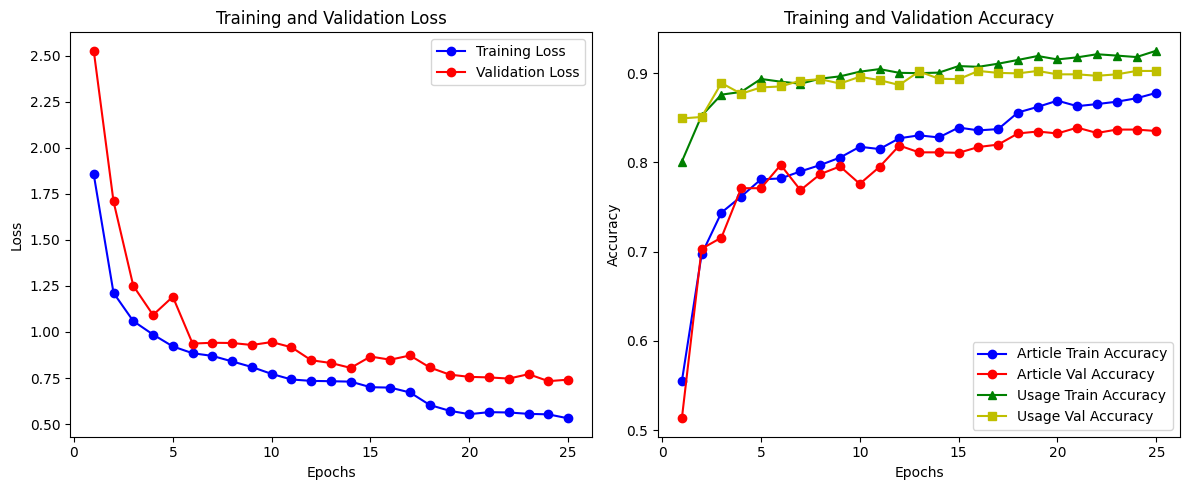

In [42]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Accuracy untuk masing-masing output
article_train_acc = history_dict['article_output_accuracy']
article_val_acc = history_dict['val_article_output_accuracy']

usage_train_acc = history_dict['usage_output_accuracy']
usage_val_acc = history_dict['val_usage_output_accuracy']

# Buat range untuk epochs
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, article_train_acc, 'bo-', label='Article Train Accuracy')
plt.plot(epochs, article_val_acc, 'ro-', label='Article Val Accuracy')
plt.plot(epochs, usage_train_acc, 'g^-', label='Usage Train Accuracy')
plt.plot(epochs, usage_val_acc, 'ys-', label='Usage Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Evaluasi model pada test_dataset
test_loss, test_article_accuracy, test_usage_accuracy = model.evaluate(test_dataset)

print("Test Loss: {:.4f}".format(test_loss))
print("Test Article Output Accuracy: {:.4f}".format(test_article_accuracy))
print("Test Usage Output Accuracy: {:.4f}".format(test_usage_accuracy))

461/461 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - article_output_accuracy: 0.8493 - loss: 0.8066 - usage_output_accuracy: 0.9028
Test Loss: 0.6970
Test Article Output Accuracy: 0.8508
Test Usage Output Accuracy: 0.9099


461/461 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step


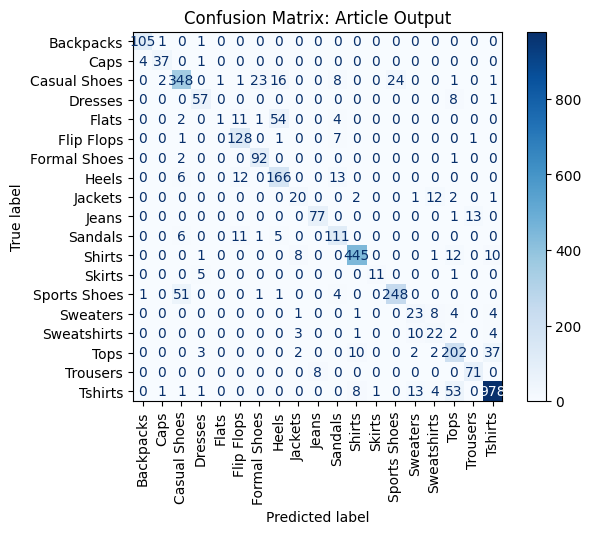

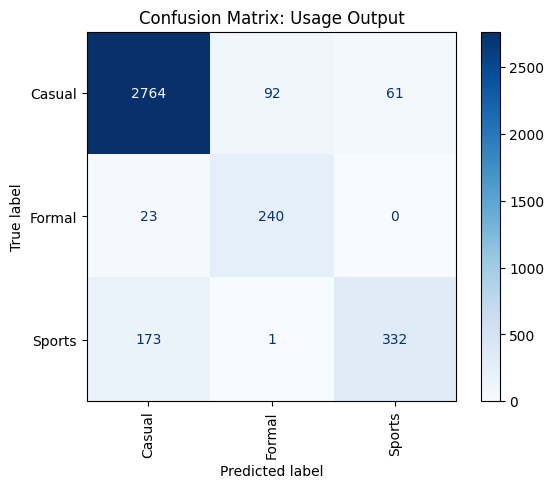

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi hasil untuk dataset validasi
predictions = model.predict(test_dataset)

# Ekstrak prediksi untuk setiap output
article_predictions = np.argmax(predictions[0], axis=1)
usage_predictions = np.argmax(predictions[1], axis=1)

# Ekstrak label asli
true_labels = list(test_dataset.as_numpy_iterator())
true_article_labels = np.concatenate([y['article_output'] for _, y in true_labels])
true_usage_labels = np.concatenate([y['usage_output'] for _, y in true_labels])

# Confusion Matrix untuk article_output
article_cm = confusion_matrix(true_article_labels, article_predictions)
ConfusionMatrixDisplay(article_cm, display_labels=article_encoder.classes_).plot(
    cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Article Output")
plt.show()

# Confusion Matrix untuk usage_output
usage_cm = confusion_matrix(true_usage_labels, usage_predictions)
ConfusionMatrixDisplay(usage_cm, display_labels=usage_encoder.classes_).plot(
    cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Usage Output")
plt.show()

# Menyimpan Model

In [52]:
model.save('/kaggle/working/hybridModel_03.h5')

In [ ]:
# model.save('./result/hybridModel_01.keras')

## Add Layer

In [47]:
# from google.colab import files

# files.upload()

In [48]:
# import tensorflow as tf

# import numpy as np

# import cv2

# from google.colab import files

# from tensorflow.keras.models import load_model

# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



# # 1. Mapping kelas untuk `articleType` dan `usage`

# article_classes = {11: 'Shirts', 9: 'Jeans', 18: 'Tshirts', 2: 'Casual Shoes', 5: 'Flip Flops',

#                    16: 'Tops', 10: 'Sandals', 15: 'Sweatshirts', 6: 'Formal Shoes', 4: 'Flats',

#                    13: 'Sports Shoes', 7: 'Heels', 3: 'Dresses', 0: 'Backpacks', 1: 'Caps',

#                    17: 'Trousers', 8: 'Jackets', 14: 'Sweaters', 12: 'Skirts'}



# usage_classes = {0: 'Casual', 1: 'Ethnic', 2: 'Formal', 3: 'Sports'}



# # 2. Load model dari file .h5

# model = load_model('model_fashion.h5')



# # 3. Fungsi untuk memproses gambar

# def preprocess_image(image_path):

#     # Baca gambar

#     img = cv2.imread(image_path)

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     img = cv2.resize(img, (224, 224))  # Ubah ukuran ke input model

#     img = preprocess_input(img)  # Normalisasi untuk MobileNetV2

#     return np.expand_dims(img, axis=0)  # Tambahkan dimensi batch



# # 4. Upload gambar dari lokal

# uploaded = files.upload()

# for file_name in uploaded.keys():

#     # 5. Preprocessing gambar

#     image_path = file_name

#     image = preprocess_image(image_path)



#     # 6. Prediksi menggunakan model

#     predictions = model.predict(image)



#     # Ekstrak prediksi untuk `articleType` dan `usage`

#     article_pred = np.argmax(predictions[0], axis=-1)

#     usage_pred = np.argmax(predictions[1], axis=-1)



#     # 7. Konversi hasil prediksi ke nama kelas

#     article_name = article_classes[article_pred]

#     usage_name = usage_classes[usage_pred]



#     print(f"Gambar: {file_name}")

#     print(f"Prediksi Article Type: {article_name}")

#     print(f"Prediksi Usage: {usage_name}")